# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev2 toc-item"><a href="#NSRDB" data-toc-modified-id="NSRDB-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>NSRDB</a></div><div class="lev2 toc-item"><a href="#SNL-RTC" data-toc-modified-id="SNL-RTC-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SNL RTC</a></div><div class="lev3 toc-item"><a href="#PVLIB-clear-sky-model" data-toc-modified-id="PVLIB-clear-sky-model-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>PVLIB clear sky model</a></div><div class="lev1 toc-item"><a href="#Exploratory-analysis" data-toc-modified-id="Exploratory-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory analysis</a></div><div class="lev2 toc-item"><a href="#Measured-GHI" data-toc-modified-id="Measured-GHI-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Measured GHI</a></div><div class="lev3 toc-item"><a href="#All-GHI-values" data-toc-modified-id="All-GHI-values-311"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>All GHI values</a></div><div class="lev3 toc-item"><a href="#GHI-values-for-overlapping-time-period-only" data-toc-modified-id="GHI-values-for-overlapping-time-period-only-312"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>GHI values for overlapping time period only</a></div><div class="lev3 toc-item"><a href="#GHI-for-every-30th-minute-(frequency-of-RTC-reduced-to-match-NSRDB)" data-toc-modified-id="GHI-for-every-30th-minute-(frequency-of-RTC-reduced-to-match-NSRDB)-313"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>GHI for every 30th minute (frequency of RTC reduced to match NSRDB)</a></div><div class="lev2 toc-item"><a href="#Modeled-GHI" data-toc-modified-id="Modeled-GHI-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Modeled GHI</a></div><div class="lev3 toc-item"><a href="#All-values" data-toc-modified-id="All-values-321"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>All values</a></div><div class="lev3 toc-item"><a href="#Overlapping-period" data-toc-modified-id="Overlapping-period-322"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Overlapping period</a></div><div class="lev3 toc-item"><a href="#Reduce-frequency-of-SNL-RTC-data" data-toc-modified-id="Reduce-frequency-of-SNL-RTC-data-323"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Reduce frequency of SNL RTC data</a></div><div class="lev2 toc-item"><a href="#Marking-clear-sky-periods-from-NSRDB" data-toc-modified-id="Marking-clear-sky-periods-from-NSRDB-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Marking clear sky periods from NSRDB</a></div><div class="lev3 toc-item"><a href="#Summary-values-of-clear-sky-periods-for-sample" data-toc-modified-id="Summary-values-of-clear-sky-periods-for-sample-331"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Summary values of clear sky periods for sample</a></div><div class="lev3 toc-item"><a href="#Summary-values-of-clear-sky-periods-for-all-NSRDB" data-toc-modified-id="Summary-values-of-clear-sky-periods-for-all-NSRDB-332"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Summary values of clear sky periods for all NSRDB</a></div><div class="lev1 toc-item"><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></div>

# Introduction

This notebook will explore how closely NSRDB satellite data and RTC ground data agree on irradiance measurements.  We will also look at the agreement between modeled irradiance from NSRDB and that supplied by PVLIB.  Ideally we hope to see that measured irradiances and modeled irradiances are close to one another for both collection methods.  If the NSRDB and ground based RTC data are different, we hope that they are different on a similar scale.

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools

import pvlib

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

# Load data

## NSRDB

In [2]:
def setup_nsrdb(df, timezone): 
    df.index = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df.index = df.index.tz_localize('UTC')
    df.index = df.index.tz_convert(timezone)
    df = df[~df.index.duplicated(keep='first')]
    df['time'] = df.index 
    df['sky_status'] = (df['Cloud Type'] == 0) & (df['GHI'] > 0)
    return df

dir_path = os.path.expanduser('~/data_sets/nsrdb/srrl_area/')
nsrdb_files = [os.path.join(dir_path, i) for i in os.listdir(dir_path) if i.endswith('csv')]
# abq_files = [os.path.join('~/abq_area', i) for i in os.listdir('./abq_area') if i.endswith('csv')]
nsrdb_df = pd.concat([pd.read_csv(f, header=2) for f in nsrdb_files])
nsrdb_df['location'] = 'srrl'
nsrdb_df = setup_nsrdb(nsrdb_df, 'US/Mountain')

## SNL RTC

In [3]:
def load_srrl():
    # filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    dir_path = os.path.expanduser('~/data_sets/srrl/with_clouds/')
    files = [os.path.join(dir_path, i) for i in os.listdir(dir_path) if i.endswith('txt')]
    # cols = ['Global_Wm2', 'Date-Time']
    # data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    df = pd.concat([pd.read_csv(f) for f in files])
    df.index = pd.to_datetime(df['DATE (MM/DD/YYYY)'] +' ' + df['MST'], format='%m/%d/%Y %H:%M')    
    df.index = df.index.tz_localize('Etc/GMT+7')
    df.index = df.index.tz_convert('US/Mountain')
    df = df.sort_index()
    df = df[~df.index.duplicated(keep='first')]
    # df = df.reindex(pd.date_range(start=df.index[0], end=df.index[-1], freq='1min')).fillna(0)
    # data = pd.Series(data['Global_Wm2'], index=data.index)
    # data[data < 200] = 0 
    # df[df < 0] = 0
    return df['Global 40-South LI-200 [W/m^2]']
srrl_data = load_srrl()

In [4]:
srrl_data[srrl_data < 0] = 0

### PVLIB clear sky model

# Exploratory analysis

In [5]:
def mean_abs_diff(this, that):
    # return np.mean(np.sqrt((this - that)**2))
    return np.mean(np.abs((this - that)))

## Measured GHI

### All GHI values

<IPython.core.display.Javascript object>


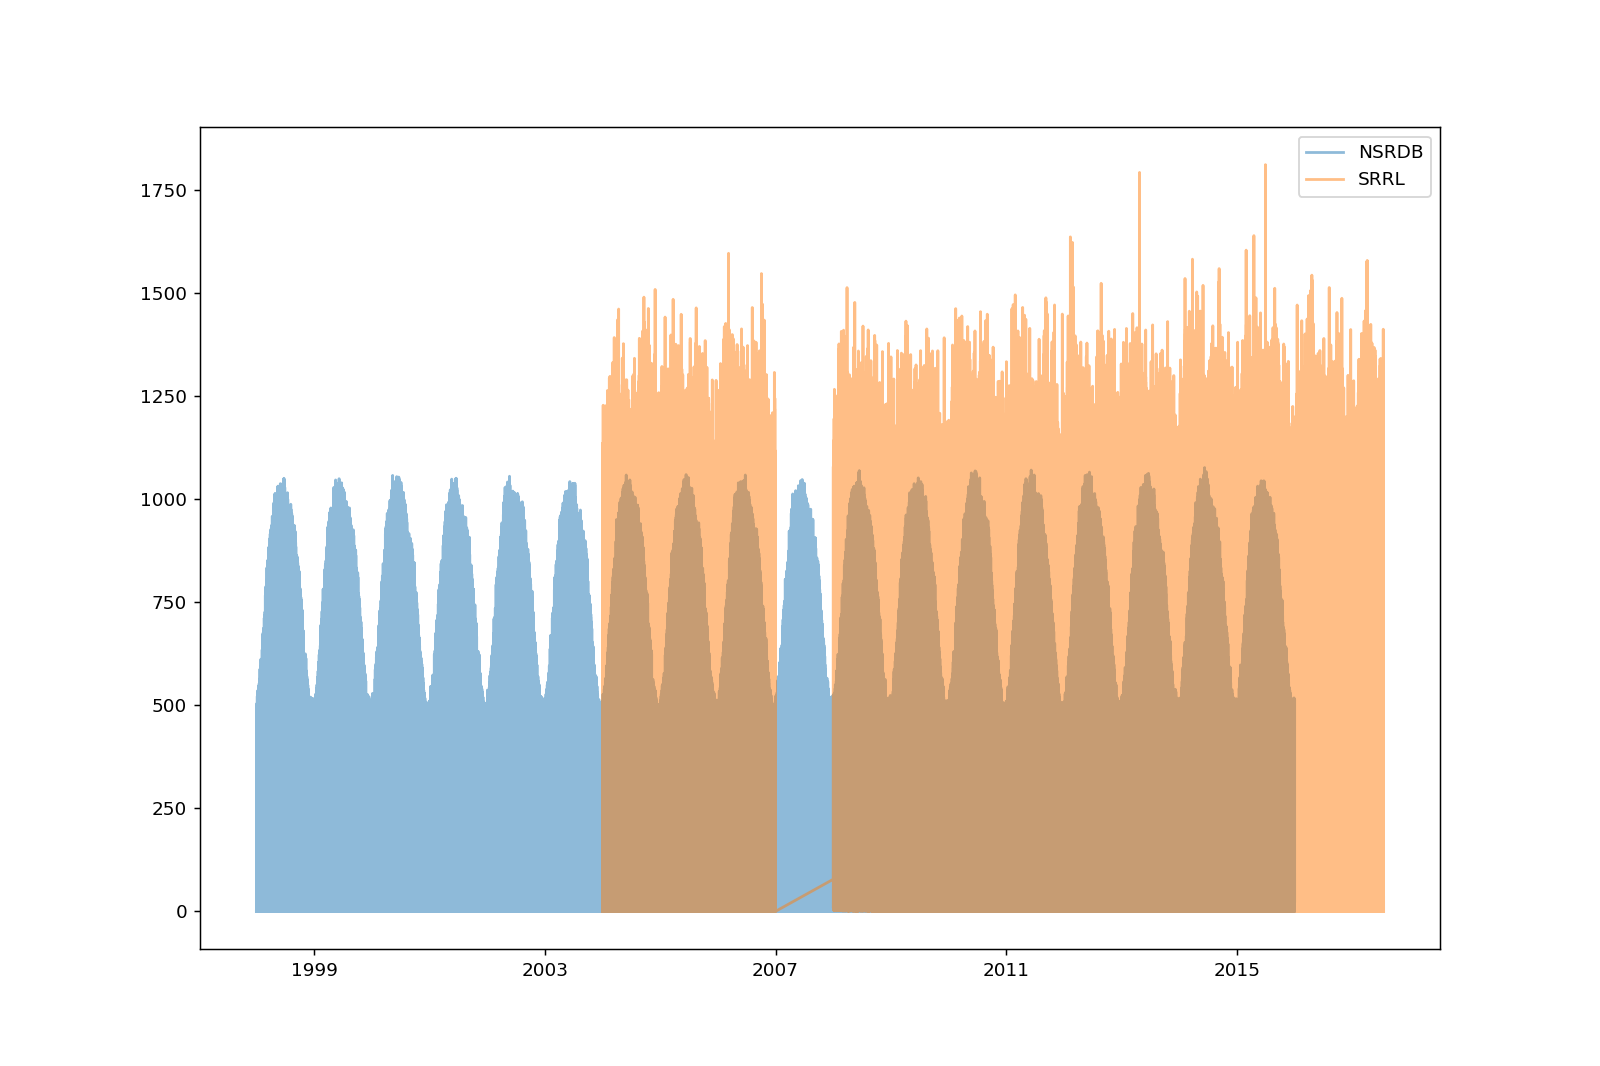

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = ax.plot(nsrdb_df.index, nsrdb_df['GHI'], alpha=.5, label='NSRDB')
_ = ax.plot(srrl_data.index, srrl_data, alpha=.5, label='SRRL')
_ = ax.legend()

About 11 total years of overlap (2004-2007, 2008-2015).  We will focus on the the 2008-2015 data as a convenient 'chunk'.

### GHI values for overlapping time period only

### GHI for every 30th minute (frequency of RTC reduced to match NSRDB)

<IPython.core.display.Javascript object>


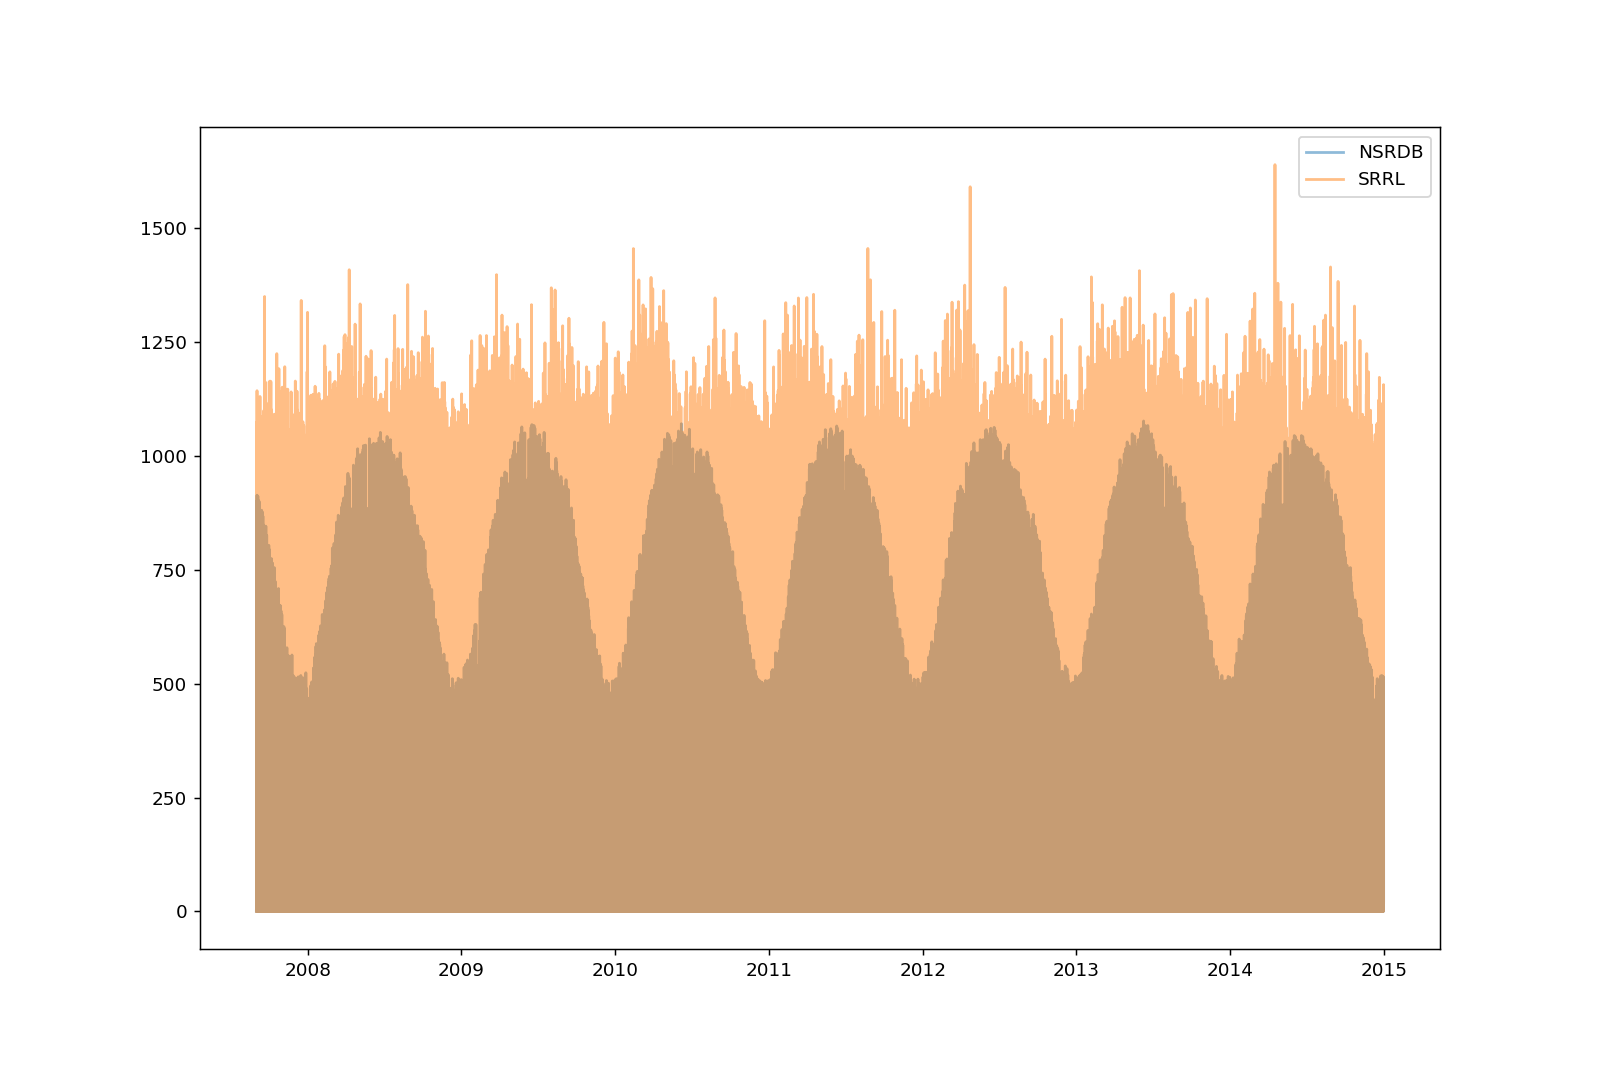

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

nsrdb_df_tmp = nsrdb_df[(nsrdb_df.index >= '09-01-2008') & (nsrdb_df.index < '01-1-2016')]
srrl_data_tmp = srrl_data[srrl_data.index.isin(nsrdb_df_tmp.index)]

_ = ax.plot(nsrdb_df_tmp.index, nsrdb_df_tmp['GHI'], alpha=.5, label='NSRDB')
_ = ax.plot(srrl_data_tmp.index, srrl_data_tmp, alpha=.5, label='SRRL')
_ = ax.legend()

In [8]:
mean_abs_diff(nsrdb_df_tmp['GHI'], srrl_data_tmp)

89.133164571964173

Matching is easier to see without extra data points that RTC contains.  Matching frequencies also allows us to calculate RMSE between the two data collection methods which is 25.46.

## Modeled GHI

In [9]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

params = {'tilt': 40, 'elevation': 1829, 'azimuth': 180, 
              'lat': 39.74, 'lon': -105.18}

rtc = make_pvlib_sys(**params)

# clear_skies = rtc.get_clearsky(srrl_data.index)
# clear_skies = pd.Series(clear_skies['ghi'], index=srrl_data.index)

### All values

Again, we have limited overlap and need to focus the analysis.

### Overlapping period

### Reduce frequency of SNL RTC data

<IPython.core.display.Javascript object>


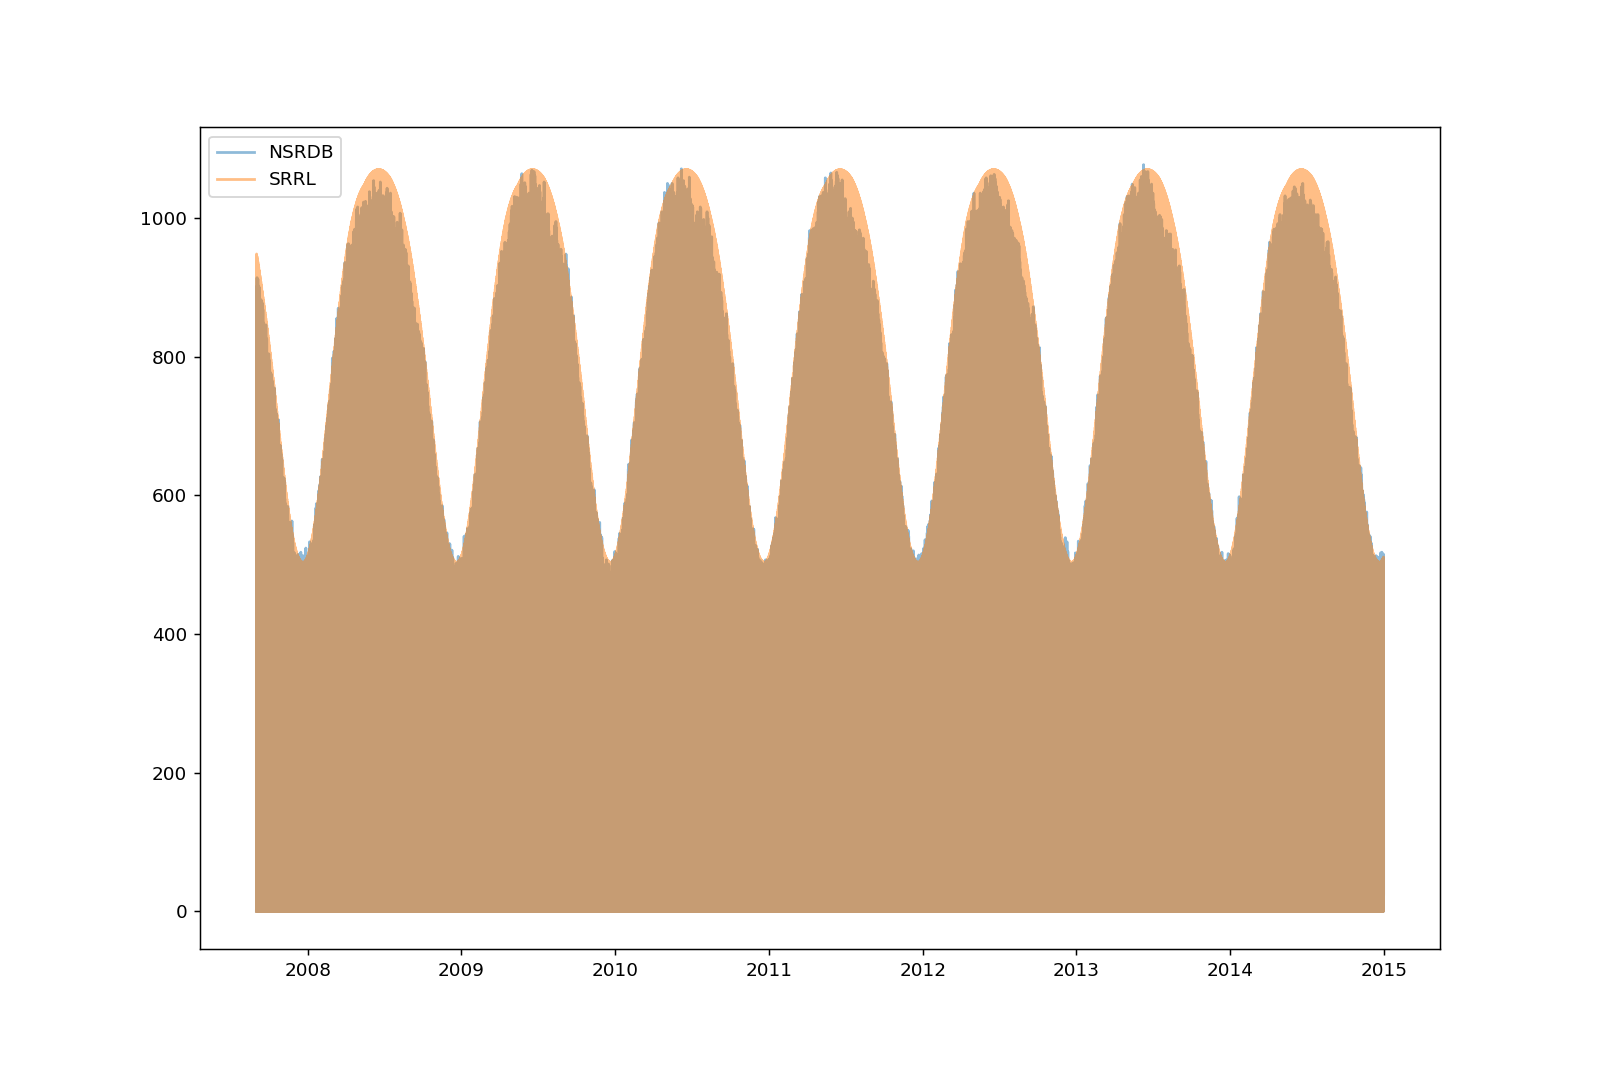

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

nsrdb_df_tmp = nsrdb_df[(nsrdb_df.index >= '9-1-2008') & (nsrdb_df.index < '1-1-2016')]
srrl_data_tmp = srrl_data[srrl_data.index.isin(nsrdb_df_tmp.index)]
# clear_skies_tmp = clear_skies[abq_data_tmp.index]

clear_skies = rtc.get_clearsky(srrl_data_tmp.index)
clear_skies = pd.Series(clear_skies['ghi'], index=srrl_data_tmp.index)

_ = ax.plot(nsrdb_df_tmp.index, nsrdb_df_tmp['Clearsky GHI'], alpha=.5, label='NSRDB')
_ = ax.plot(clear_skies.index, clear_skies, alpha=.5, label='SRRL')
_ = ax.legend()

In [11]:
mean_abs_diff(nsrdb_df_tmp['Clearsky GHI'], clear_skies)

8.5073200271680065

## Marking clear sky periods from NSRDB

<IPython.core.display.Javascript object>


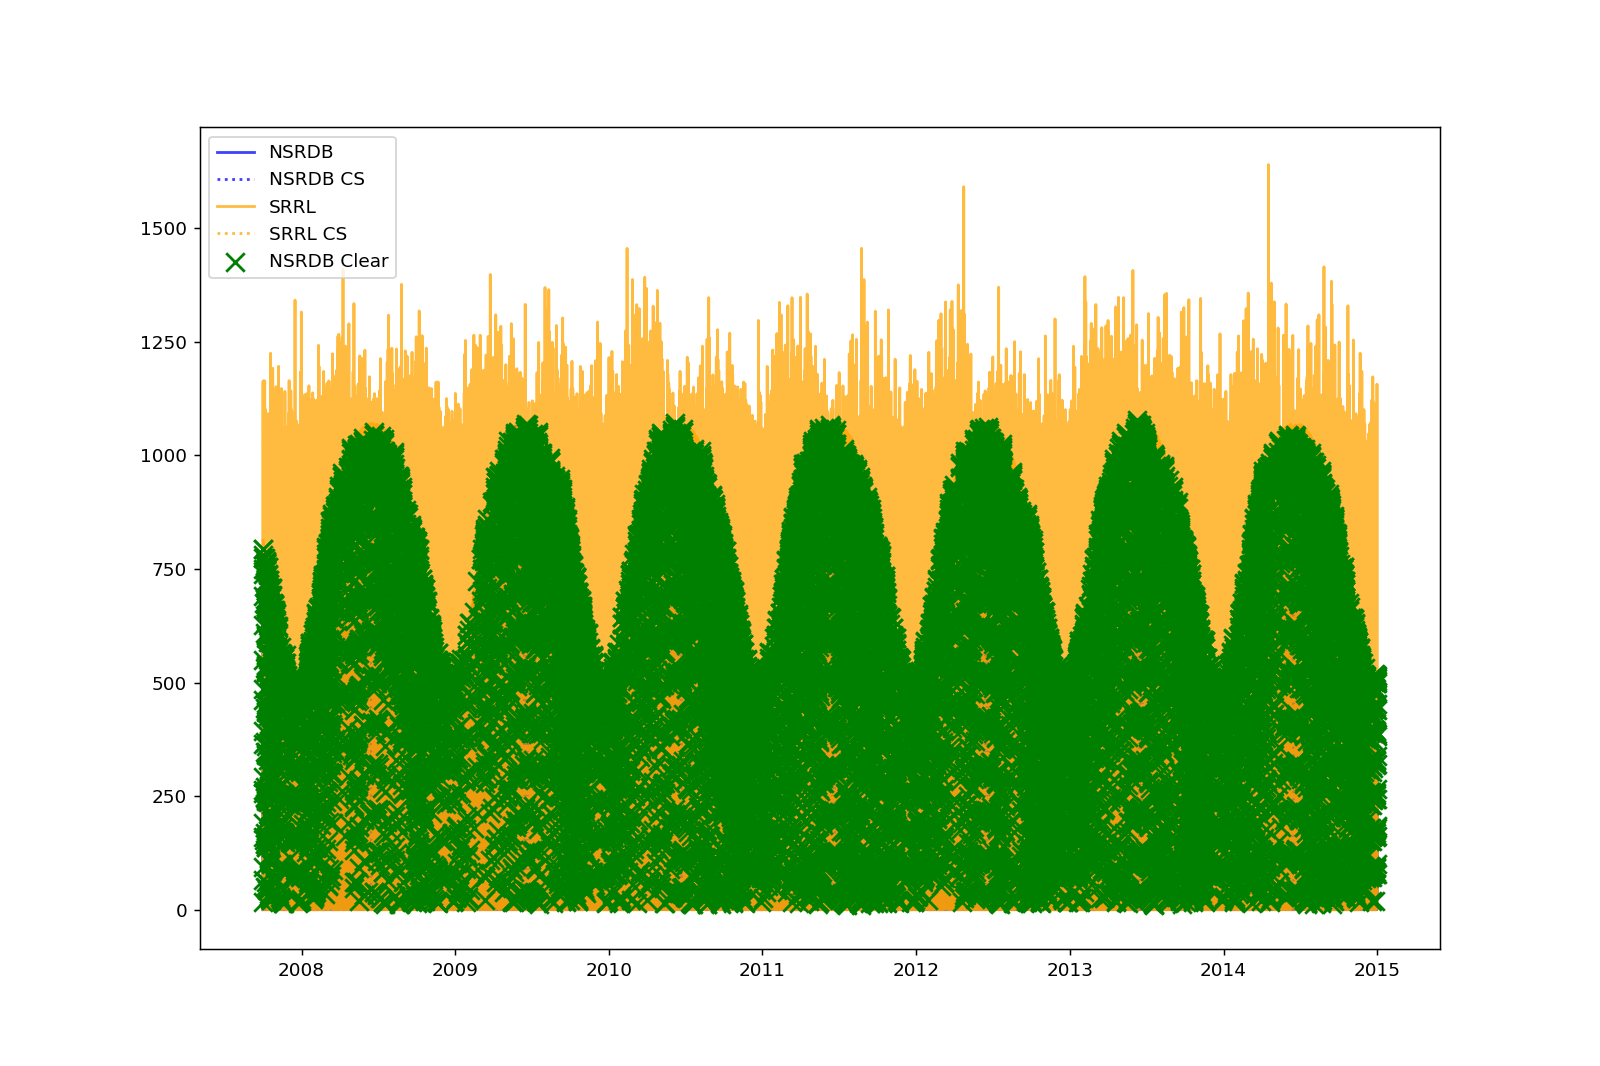

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

nsrdb_df_tmp = nsrdb_df[(nsrdb_df.index >= '10-1-2008') & (nsrdb_df.index < '1-1-2016')]
srrl_data_tmp = srrl_data[srrl_data.index.isin(nsrdb_df_tmp.index)]

clear_skies = rtc.get_clearsky(srrl_data_tmp.index)
clear_skies_tmp = pd.Series(clear_skies['ghi'], index=srrl_data_tmp.index)

_ = ax.plot(nsrdb_df_tmp.index, nsrdb_df_tmp['GHI'], alpha=.75, label='NSRDB', color='blue')
_ = ax.plot(nsrdb_df_tmp.index, nsrdb_df_tmp['Clearsky GHI'], alpha=.75, label='NSRDB CS', linestyle=':', color='blue')
_ = ax.plot(srrl_data_tmp.index, srrl_data_tmp, alpha=.75, label='SRRL', color='orange')
_ = ax.plot(srrl_data_tmp.index, clear_skies_tmp, alpha=.75, label='SRRL CS', linestyle=':', color='orange')
_ = ax.scatter(nsrdb_df_tmp[nsrdb_df_tmp['sky_status']].index, 
               nsrdb_df_tmp[nsrdb_df_tmp['sky_status']]['GHI'], 
               marker='x', color='green', alpha=1, label='NSRDB Clear', zorder=100, s=100)
_ = ax.legend()

At periods when the NSRDB GHI and SRRL GHI match, the agreement for clearsky periods between the data sets look ok.  It is much harder to tell when the measured GHI values become misaligned (in the winter months).

### Summary values of clear sky periods for sample

In [22]:
print(len(srrl_data_tmp), len(nsrdb_df_tmp))

127044 127044


In [23]:
srrl_data_tmp.index.duplicated().astype(int).sum()

0

In [24]:
# clear periods from NSRDB
clear_mask = (nsrdb_df_tmp['sky_status'] == True)

# MAD between NSRDB and RTC values during clear periods (from NSRDB)
nsrdb_clear_periods = nsrdb_df_tmp[clear_mask]['GHI'].values
srrl_clear_periods = srrl_data_tmp[clear_mask].values
print('Clear period mean abs diff between NSRDB, RTC: ', mean_abs_diff(nsrdb_clear_periods, srrl_clear_periods))

# MAD between NSRDB and RTC values during cloudy periods (from NSRDB)
nsrdb_cloudy_periods = nsrdb_df_tmp[~clear_mask]['GHI'].values
srrl_cloudy_periods = srrl_data_tmp[~clear_mask].values
print('Cloudy period mean_abs_diff between NSRDB, RTC: ', mean_abs_diff(nsrdb_cloudy_periods, srrl_cloudy_periods))

# Ratio of measured to modeled irradiance (NSRDB) during clear periods (from NSRDB)
print('Clear period ratio - NSRDB: ', 
      np.mean(nsrdb_df_tmp[clear_mask]['GHI'] / nsrdb_df_tmp[clear_mask]['Clearsky GHI']), ' +/- ',
      np.std(nsrdb_df_tmp[clear_mask]['GHI'] / nsrdb_df_tmp[clear_mask]['Clearsky GHI']))

# Ratio of measured to modeled irradiance (SNL RTC) during clear periods (from NSRDB)
print('Clear period ratio - SNL RTC: ', 
      np.mean(srrl_data_tmp[clear_mask] / clear_skies_tmp[clear_mask]), ' +/- ',
      np.std(srrl_data_tmp[clear_mask] / clear_skies_tmp[clear_mask]))

# Percent error of modeled to measured irradiance from NSRDB during clear sky periods (from NSRDB)
print('Clear period pct diff - NSRDB: ', 
      np.mean(np.abs((nsrdb_df_tmp[clear_mask]['GHI'] - nsrdb_df_tmp[clear_mask]['Clearsky GHI']) / 
                      nsrdb_df_tmp[clear_mask]['Clearsky GHI']).replace([-np.inf, np.inf, np.nan], 0)), ' +/- ',
      np.std(np.abs((nsrdb_df_tmp[clear_mask]['GHI'] - nsrdb_df_tmp[clear_mask]['Clearsky GHI']) / 
                    nsrdb_df_tmp[clear_mask]['Clearsky GHI']).replace([-np.inf, np.inf, np.nan], 0)))

# Percent error of modeled to measured irradiance from SNL RTC during clear sky periods (from NSRDB)
print('Clear period pct diff - SNL RTC: ', 
      np.mean(np.abs((srrl_data_tmp[clear_mask] - clear_skies_tmp[clear_mask]) / clear_skies_tmp[clear_mask]).replace([-np.inf, np.inf, np.nan], 0)), '+/- ',
      np.std(np.abs((srrl_data_tmp[clear_mask] - clear_skies_tmp[clear_mask]) / clear_skies_tmp[clear_mask]).replace([-np.inf, np.inf, np.nan], 0)))

Clear period mean abs diff between NSRDB, RTC:  204.638464544
Cloudy period mean_abs_diff between NSRDB, RTC:  69.3707067925
Clear period ratio - NSRDB:  1.0  +/-  0.0
Clear period ratio - SNL RTC:  1.37477245478  +/-  0.73296335826
Clear period pct diff - NSRDB:  0.0  +/-  0.0
Clear period pct diff - SNL RTC:  0.558652261787 +/-  0.604646448607


Selecting clear sky periods from NSRDB is quite simple - select a ratio 1:1 for measured to clearsky ratio, or by calculating a 0% absolute error between the measured GHI and clearsky GHI.  This is discouraging because it's unrealistic to assume that a clearsky model and a measured irradiance curve will have a 1:1 correspondence during clear periods.  A potential way to work around this issue is generate the statistical clear sky from NSRDB data and then generate it for datasets we want to predict on as well.  

### Summary values of clear sky periods for all NSRDB

# Conclusion

It is troubling to see that the NSRDB and SRRL data differ so greatly in measured GHI.  The SRRL data displays almost no seasonality which I assume is a large reason for the large mean absolute difference of the two data sets.  The SRRL data has been analyzed befored using the 'model free' clearsky detection, and we saw that the modeled irradiance (from PVLib) did not 'match up' well with the measured data.  It's possible that this dataset will require a statistical clear sky curve to detect clear periods.  This was used with some success on the limited SNL RTC data set.  It will still be worthwhile to go through the steps of training a ML model on the NSRDB data and see if/how it generalizes to the SRRL data.  